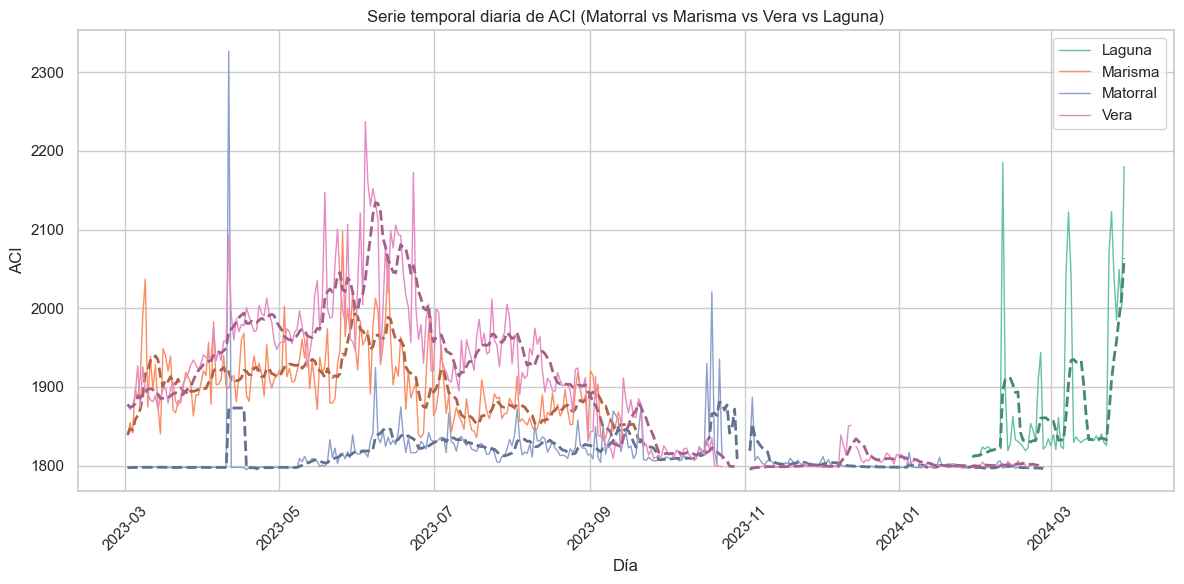

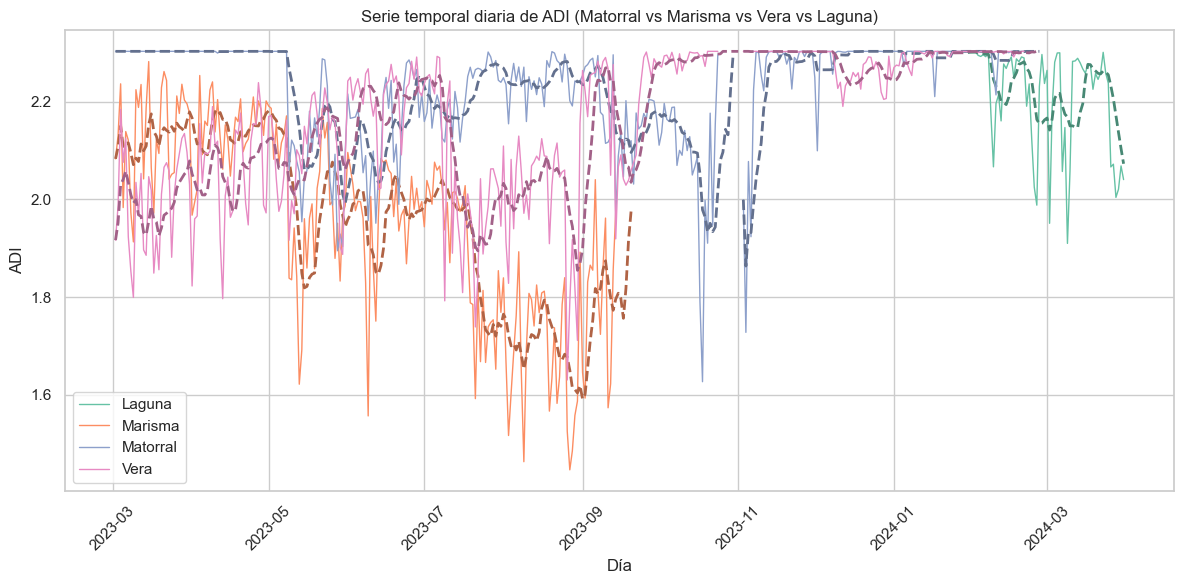

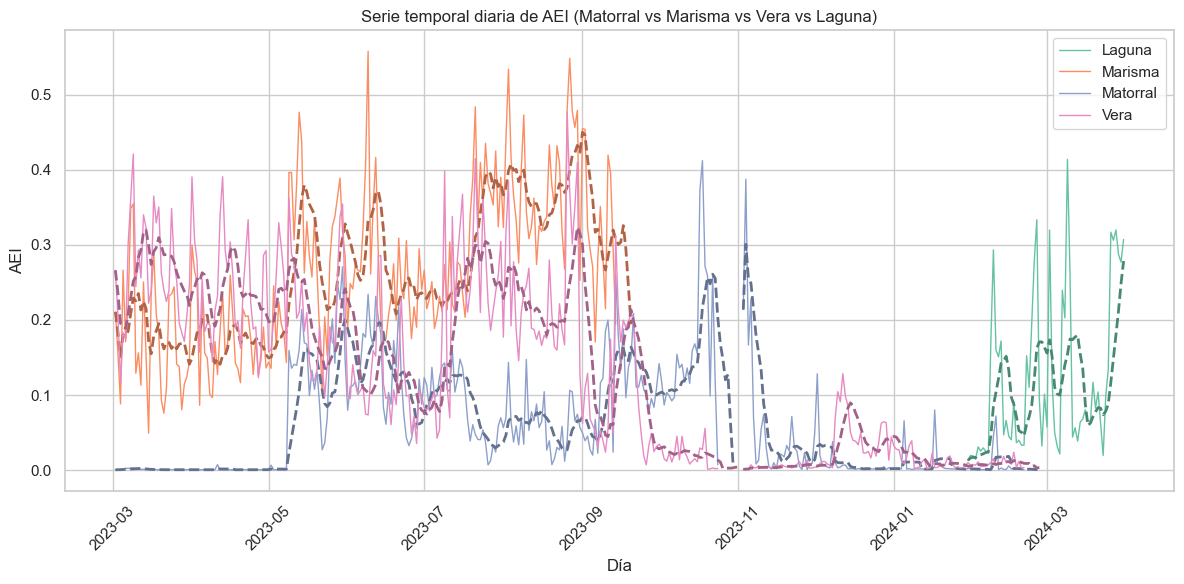

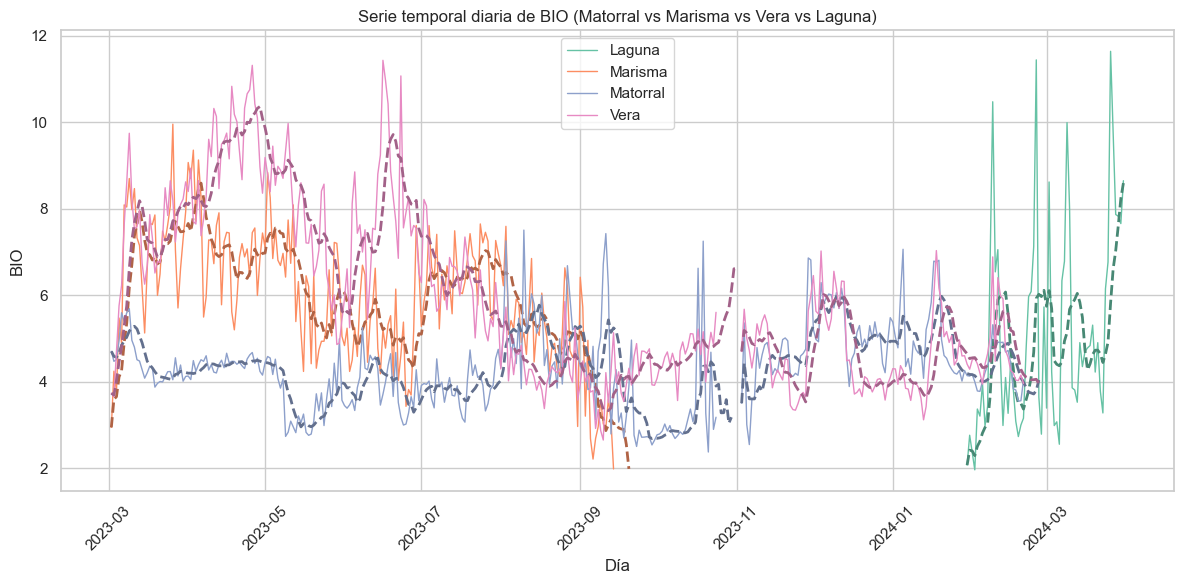

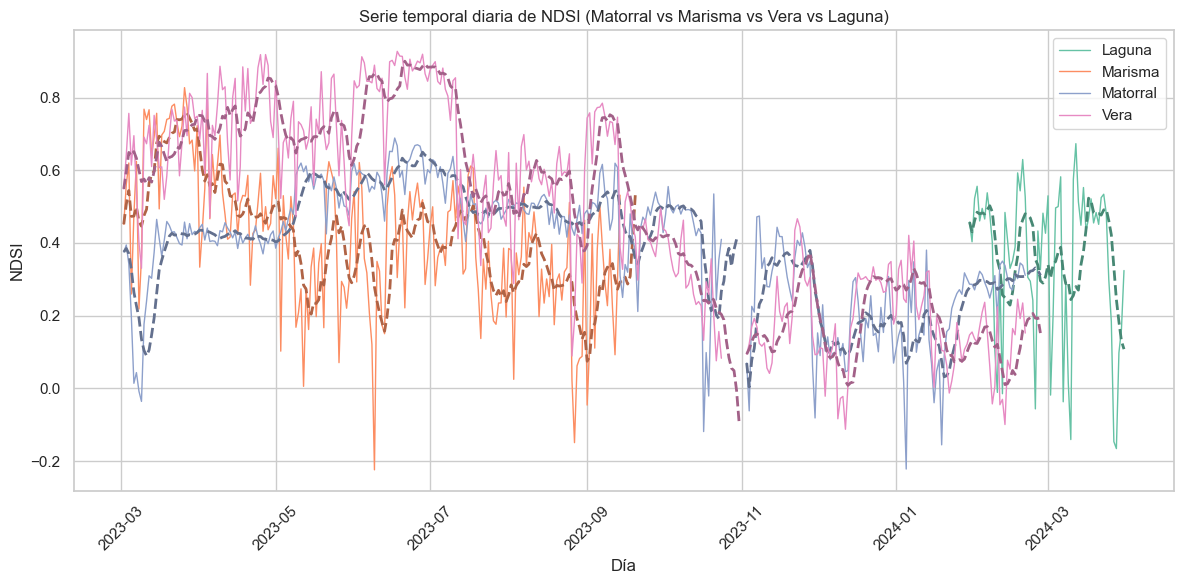

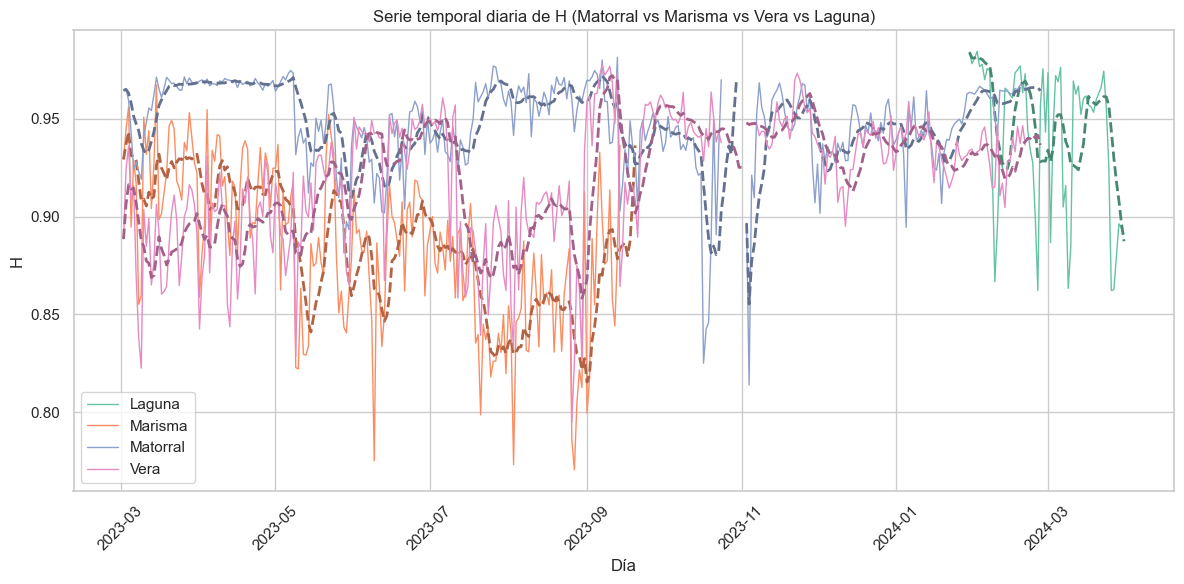

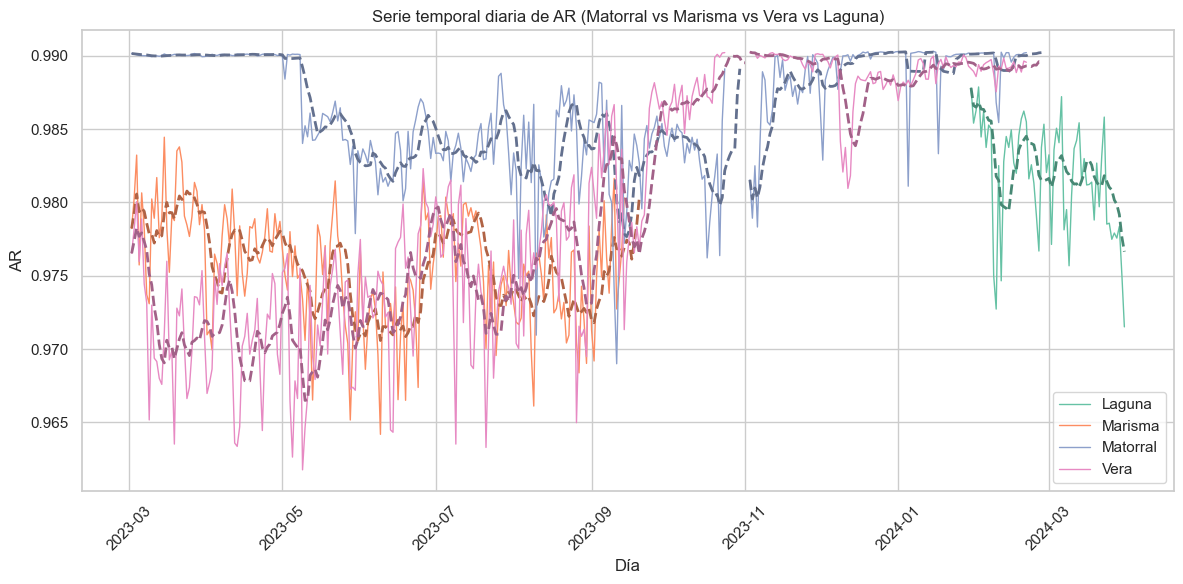

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# --- 1. Conexión y extracción de datos desde SQLite ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
conn.close()

# Convertir "datetime" a tipo datetime y crear la columna "day"
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["day"] = df["datetime"].dt.date

# Convertir la columna 'day' a datetime para facilitar la reindexación
df["day"] = pd.to_datetime(df["day"])

# --- Filtrar datos entre marzo 2023 y marzo 2024 ---
start_date = pd.to_datetime("2023-03-01")
end_date = pd.to_datetime("2024-03-31")
df = df[(df["day"] >= start_date) & (df["day"] <= end_date)]

# Lista de índices a analizar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Filtrar filas que tengan datos en todos los índices y en "zone"
df_indices = df.dropna(subset=indices + ["zone"])

# --- Paleta personalizada ---
sorted_zones = sorted(df_indices["zone"].unique())
palette = sns.color_palette("Set2", n_colors=len(sorted_zones))
zone_colors = dict(zip(sorted_zones, palette))

# --- 2. Filtrar solo para las zonas "Matorral", "Marisma", "Vera" y "Laguna" ---
df_filtered = df_indices[df_indices["zone"].isin(["Matorral", "Marisma", "Vera", "Laguna"])]

# --- 3. Agregación Diaria por Zona ---
daily_zone_filtered = df_filtered.groupby(["zone", "day"])[indices].mean().reset_index()

# --- 4. Eliminar los 5 valores más altos y más bajos del índice ACI ---
aci_sorted = daily_zone_filtered.sort_values(by="ACI")
aci_filtered = aci_sorted.iloc[5:-5]

# --- 5. Visualización de Series Temporales con líneas de tendencia ---
for idx in indices:
    plt.figure(figsize=(12, 6))

    # Seleccionar el dataset adecuado: se usa aci_filtered para ACI, o daily_zone_filtered para los demás
    dataset = aci_filtered if idx == "ACI" else daily_zone_filtered

    # Calcular el rango completo de fechas para el dataset actual
    min_day = dataset["day"].min()
    max_day = dataset["day"].max()
    full_date_range = pd.date_range(start=min_day, end=max_day, freq='D')

    # Iterar sobre las zonas ordenadas según la paleta personalizada
    for zone in sorted_zones:
        # Extraer la serie temporal para cada zona y reindexarla para mostrar huecos en días sin datos
        zone_data = dataset[dataset["zone"] == zone].sort_values(by="day").set_index("day")
        zone_data = zone_data.reindex(full_date_range)

        # Línea de la serie original
        plt.plot(zone_data.index, zone_data[idx], label=zone, color=zone_colors[zone], linewidth=1)

        # Línea de tendencia: usando media móvil de 7 días
        trend = zone_data[idx].rolling(window=7, min_periods=1).mean()
        # Calcular un color más oscuro multiplicando cada componente por 0.7
        darker_color = tuple([c * 0.7 for c in zone_colors[zone]])
        plt.plot(zone_data.index, trend, color=darker_color, linewidth=2, linestyle="--")

    plt.title(f"Serie temporal diaria de {idx} (Matorral vs Marisma vs Vera vs Laguna)")
    plt.xlabel("Día")
    plt.ylabel(idx)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()